### LoopFlopy Example 3 - Adding Heterogeneity

In [7]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import sys
import os
import pickle
import flopy
import geopandas as gpd
from shapely.geometry import LineString,Point,Polygon,MultiPolygon,MultiPoint,shape

%load_ext autoreload
%autoreload 2

import loopflopy
import loopflopy.utils as utils

print(loopflopy.__file__)
modules = utils.list_modules(loopflopy)
#for module in modules: print(module)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
c:\users\00105295\projects\loopflopy\loopflopy\__init__.py


### 1. Setup Project

In [8]:
# Project setup
name = 'example'
workspace = '../modelfiles/'
results = '../results/'
figures = '../figures/'
triexe = '../exe/triangle.exe'
mfexe_name = '../exe/mf6.exe'

from loopflopy.project import Project
project = Project(name, workspace, results, figures, triexe, mfexe_name)

### 2. Spatial

In [9]:
from loopflopy.spatial import Spatial
spatial = Spatial(epsg = 28350)

import process_spatial

process_spatial.make_bbox_shp(spatial, x0 = 348000, x1 = 390000, y0 = 6503000, y1 = 6520000) # x1 = 415000
process_spatial.model_boundary(spatial, boundary_buff = 500, simplify_tolerance = 800, node_spacing = 1000)
#process_spatial.model_boundary(spatial, boundary_buff = 1000, simplify_tolerance = 800, node_spacing = 2000)
spatial.x0, spatial.x1, spatial.y0, spatial.y1

(363206.86262235837, 390000.0, 6503000.0380154895, 6520000.0)

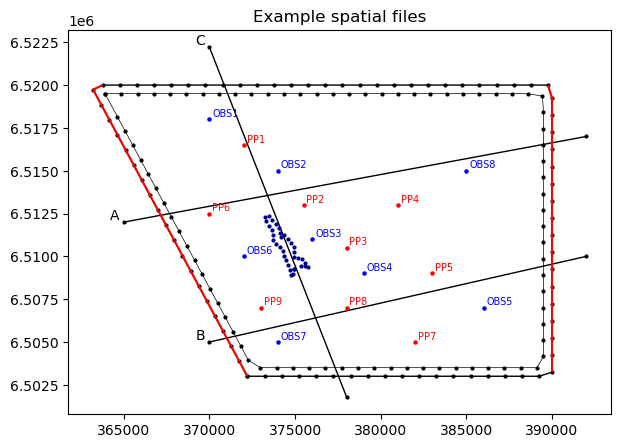

In [10]:
process_spatial.obs_bores(spatial)
process_spatial.geo_bores(spatial)
process_spatial.pump_bores(spatial)
process_spatial.pilot_points(spatial)
process_spatial.head_boundary(spatial)
process_spatial.faults(spatial)
process_spatial.lakes(spatial)

spatial.xsection_names = ['A', 'B', 'C']
spatial.xsections = [
                     [(365000, 6512000),(392000, 6517000)], 
                     [(370000, 6505000),(392000, 6510000)],
                     [(370000, 6522200),(378000, 6501800)]
                     ]
process_spatial.plot_spatial(spatial, 
                             obsbores = True, 
                             pilotpoints = True,
                             pumpbores = False, 
                             geobores = False, 
                             xsections = True, 
                             fault = False)

In [11]:
# Create a map
m = spatial.obsbore_gdf.explore(location=[-31.4, 115.8], zoom_start=10, popup = 'ID')
spatial.model_boundary_gdf.explore(m=m, fill = False)
#spatial.faults_gdf.explore(m=m, color = 'red')
spatial.pumpbore_gdf.explore(m=m, color = 'red', popup = 'ID')

c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\pyproj\transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(
c:\Users\00105295\AppData\Local\anaconda3\envs\loopflopy\Lib\site-packages\pyproj\transformer.py:817: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return self._transformer._transform_point(


### 3. Structural Model

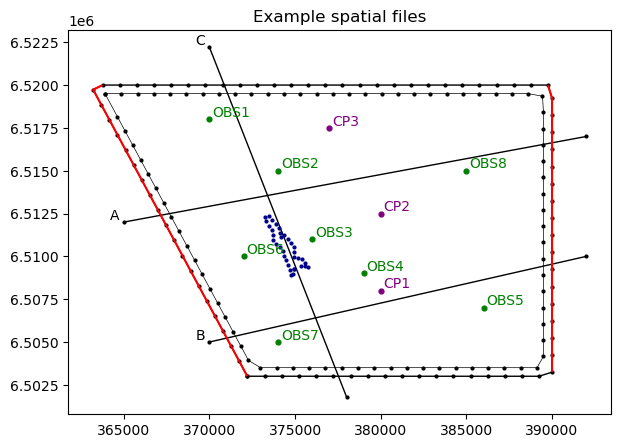

In [12]:
process_spatial.plot_spatial(spatial, 
                             obsbores = False, 
                             pilotpoints = False,
                             pumpbores = False, 
                             geobores = True, 
                             controlpoints = True,
                             xsections = True, 
                             fault = False)

In [13]:
# Create Structural Model
geodata_fname = '../data/example_data.xlsx'
data_sheetname = 'geo_bores'
strat_sheetname = 'strat'
bbox = [(348000, 6500000, -1000), (400000, 6550000, 500)] #[(x0, y0, z0), (x1, y1, z1)]
from loopflopy.structuralmodel import StructuralModel
structuralmodel = StructuralModel(spatial, bbox, geodata_fname, data_sheetname, strat_sheetname)

import process_structural
process_structural.prepare_strat_column(structuralmodel)
process_structural.prepare_geodata(structuralmodel, spatial, Fault = False)
process_structural.create_structuralmodel(structuralmodel, Fault = False)

structuralmodel.faults = ['Fault']

1.6.11


C:\Users\00105295\AppData\Roaming\Python\Python312\site-packages\LoopStructural\modelling\core\geological_model.py:648: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap, n_units)


In [14]:
#structuralmodel.data

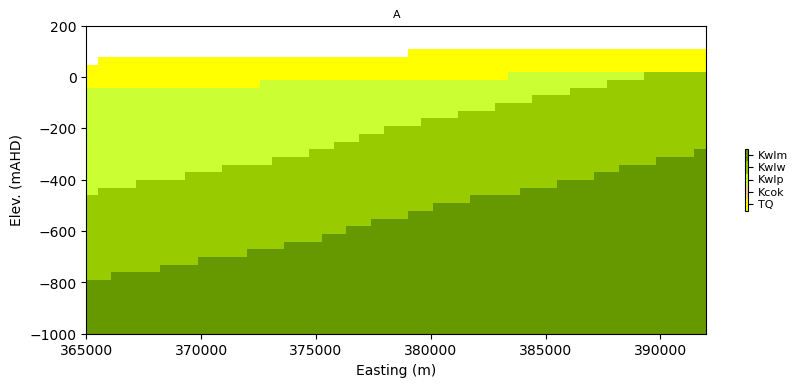

<Figure size 640x480 with 0 Axes>

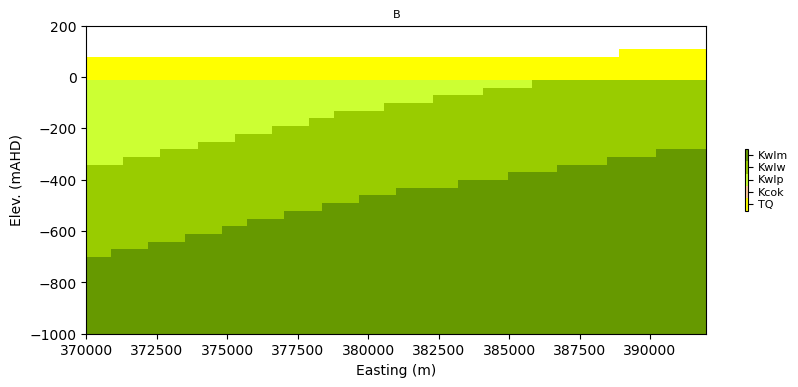

<Figure size 640x480 with 0 Axes>

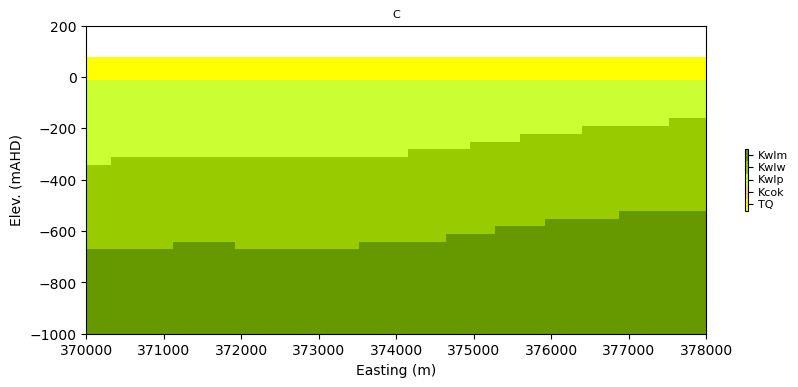

<Figure size 640x480 with 0 Axes>

In [15]:
z0 = -1000 # just for plotting. Make sure within bbox of structural model
z1 = 200   # just for plotting. Make sure within bbox of structural model
nh, nz = 50, 40 # plotting resolution

for i in range(len(spatial.xsections)):
    start = spatial.xsections[i][0]
    end   = spatial.xsections[i][1]

    structuralmodel.plot_xytransect(title = spatial.xsection_names[i], start = start, end = end, z0 = z0, z1 = z1, nh = nh, nz = nz)

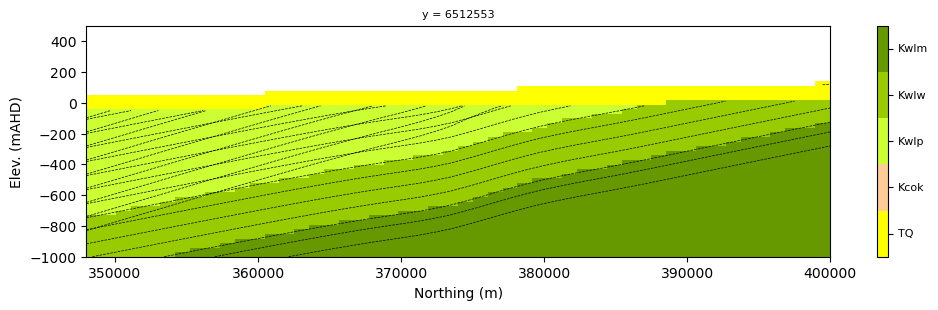

In [ ]:
transect_y = [6512553] 
structuralmodel.plot_ytransects2(transect_y, nx = 50, nz = 50, dz = 100)#, faults = False,
#structuralmodel.plot_ytransects(transect_y, nx = 50, nz = 50)#, z0 = -1200, z1 = 200) 
#structuralmodel.data

In [11]:
def evaluate_model(structuralmodel, start, end, z0, z1, nh, nz, **kwargs):

    x0 = start[0]
    y0 = start[1]
    x1 = end[0]
    y1 = end[1]

    x = np.linspace(x0, x1, nh)
    y = np.linspace(y0, y1, nh)        
    z = np.linspace(z0, z1, nz)

    X = np.tile(x, (len(z), 1)) 
    Y = np.tile(y, (len(z), 1)) 
    Z = np.tile(z[:, np.newaxis], (1, nh))  # Repeat z along columns (nh times)

    labels = structuralmodel.strat_names[1:]
    ticks = [i for i in np.arange(0,len(labels))]
    boundaries = np.arange(-1,len(labels),1)+0.5

    a = np.array([X.flatten(),Y.flatten(),Z.flatten()]).T
    V = structuralmodel.model.evaluate_model(a).reshape(np.shape(X))

    return V

i = 0 # first transect
start = spatial.xsections[i][0]
end   = spatial.xsections[i][1]
nh, nz = 50, 50
V = evaluate_model(structuralmodel, start, end, z0, z1, nh, nz)
np.unique(V.flatten(), return_counts=True)

(array([-1,  0,  2,  3,  4]), array([210, 215, 421, 711, 943]))

Ground
(60, 60)
TQ
(60, 60)
Kcok
(60, 60)
Leed
(60, 60)


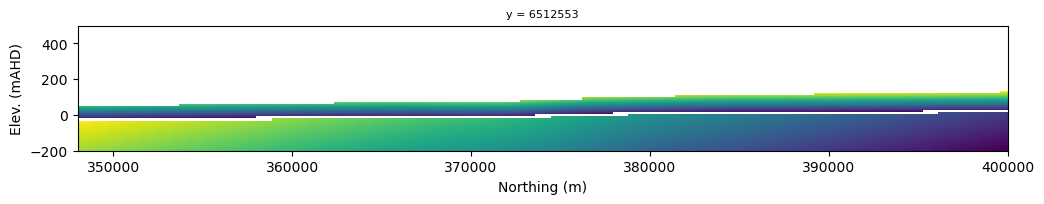

In [12]:
def plot_scalarfield(self, transect_y, nx, nz, **kwargs):

        self.sequence_names = []
        for item in self.strat['sequence'].tolist():
            if item not in self.sequence_names:
                self.sequence_names.append(item)

        x0 = kwargs.get('x0', self.x0)
        z0 = kwargs.get('z0', self.z0)
        x1 = kwargs.get('x1', self.x1)
        z1 = kwargs.get('z1', self.z1)
        
        z = np.linspace(z0, z1, nz)
        x = np.linspace(x0, x1, nx)
        X,Z = np.meshgrid(x,z)

        labels = self.strat_names[1:]
        ticks = [i for i in np.arange(0,len(labels))]
        boundaries = np.arange(-1,len(labels),1)+0.5
        Y = np.zeros_like(X)
        Y[:,:] = transect_y[0]
        V = self.model.evaluate_model(np.array([X.flatten(),Y.flatten(),Z.flatten()]).T).reshape(np.shape(Y))
        
        for i, n in enumerate(transect_y):
            fig = plt.figure(figsize=(12, 3))
            ax = plt.subplot(len(transect_y), 1, i+1)
            

            val_above = 0
            # Evaluate scalar fields for each feature to plot contours
            for feat in self.sequence_names:
                print(feat)
                A = self.model.evaluate_feature_value(feat, np.array([X.flatten(),Y.flatten(),Z.flatten()]).T).reshape(np.shape(Y))
                print(A.shape)
                ax.imshow(np.ma.masked_where(V<0,A), origin = "lower", extent = [x0,x1,z0,z1])

            # Evaluate faults to plot
            #for fault in self.faults:
            #    F = self.model.evaluate_feature_value(fault, np.array([X.flatten(),Y.flatten(),Z.flatten()]).T).reshape(np.shape(Y))
            #    ax.contour(X, Z, F, levels = [0], colors = 'Black', linewidths=2., linestyles = 'dashed') 
            if i < (len(transect_y)-1):
                ax.set_xticks(ticks = [], labels = [])
            else:
                ax.set_xlabel('Northing (m)')

            #cbar.ax.set_yticks(ticks = ticks, labels = labels, size = 8, verticalalignment = 'center')    
            ax.set_title("y = " + str(transect_y[i]), size = 8)
            ax.set_ylabel('Elev. (mAHD)')
            ax.set_aspect('10') #0.5, 'equal'
            #plt.axis('equal')
            plt.savefig('../figures/structural_ytransects.png')
            plt.show()

plot_scalarfield(structuralmodel, transect_y, nx = 60, nz = 60, z0 = -200, )#z1 = 000) #x0 = 370000, x1 = 374000, 

### 4. Meshing

In [13]:
# Create mesh object
from loopflopy.mesh import Mesh
special_cells = {
                 'chd': ['east', 'west'], 
                 'wel': ['pumpbores'], 
                 'obs': ['obsbores'],
                 'poly': ['lake'], 
                 }
mesh = Mesh(plangrid = 'tri', special_cells = special_cells) # special cells to identify as arguements 

In [14]:
# Define mesh parameters and create mesh
mesh.modelmaxtri = 500000
mesh.boundmaxtri = 999999999
mesh.angle = 32   # minimum triangle angles
mesh.radius1 = 400 # 50, 200 radius of inner circle around pumping bores
mesh.radius2 = 800 # 200, 600 radius of outer circle around pumping bores
mesh.boremaxtri = 99999999

mesh.create_bore_refinement(spatial)

node_list = ['bore_refinement_nodes','lake_nodes']#fault_nodes', 'bore_refinement_nodes',]
polygon_list = ['model_boundary_poly', 'inner_boundary_poly']

mesh.prepare_nodes_and_polygons(spatial, node_list, polygon_list)
mesh.create_mesh(project, spatial)

print('number of cells in plan = ', mesh.ncpl)

bore_refinement_nodes
lake_nodes
number of cells in plan =  1614


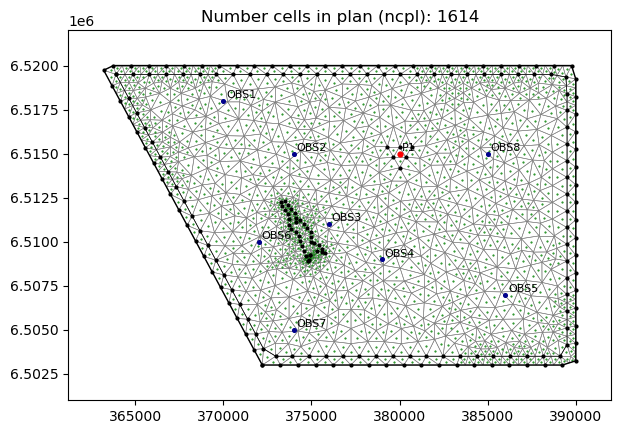

In [15]:
xlim = [spatial.x0 - 2000, spatial.x1 + 2000]
ylim = [spatial.y0 - 2000, spatial.y1 + 2000]

features = ['wel', 'obs', 'lake']
mesh.plot_cell2d(spatial, features, xlim = xlim, ylim = ylim)

### 5. Find Cell IDs of spatial features

Group =  chd ['east', 'west']
flag = 1
chd_east_cells [256 265 569 258 261 533 260 530 263 701 290 699 1112 1116 289 269 270 278
 276 281 273 283 274 282 284 287 394 354 345 357 346 365 352 358 349 363
 350 726 730 360 367 714 378 715 380 381 717]
chd_west_cells [15 13 17 14 2 0 3 5 4 7 34 32 35 43 24 22 25 27 26 29 165 144 108 114 111
 1087 1083 678 113 680 112 100 487 98 486 101 490 104 489 491 102 493 105
 122 497 142 499 496 199 495 120 123 125 124]
Group =  wel ['pumpbores']
flag = 3
Group =  obs ['obsbores']
flag = 4
Group =  poly ['lake']
flag = 5
[0 1 2 3 4 5]
[0 1 2 3 4 5]


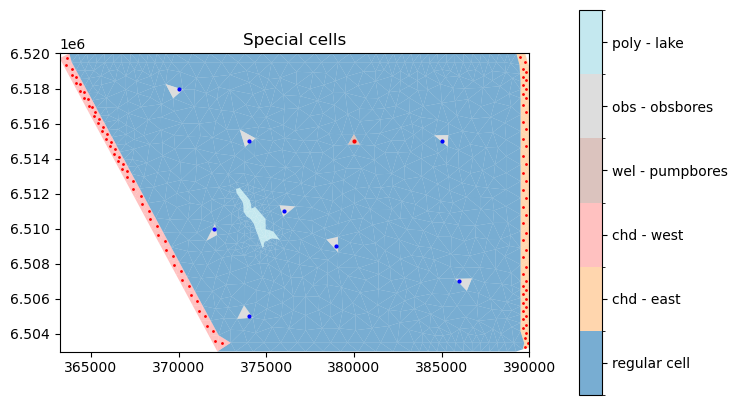

In [16]:
# Locate special cells and plot
mesh.locate_special_cells(spatial)

xlim = [355000, 370000]
ylim = [6525000, 6535000]

mesh.plot_feature_cells(spatial, xlim = None, ylim = None)

### 5. Geomodel

In [17]:
# Set up Geomodel (lithological block model of cells)
scenario = 'example'
vertgrid = 'con'    # {voxel: nlay, z0, z1} {con:   nls, res} {con2:  nls, res, max_thick}
z0, z1 = -1000, 200 

from loopflopy.geomodel import Geomodel
geomodel = Geomodel(scenario, vertgrid, z0, z1, nls = 3, res = 3) # surfaces calculated at a 3m resolution

geomodel.evaluate_structuralmodel(mesh, structuralmodel)
geomodel.create_model_layers(mesh, structuralmodel)

geomodel.vgrid = flopy.discretization.VertexGrid(vertices=mesh.vertices, cell2d=mesh.cell2d, ncpl = mesh.ncpl, top = geomodel.top_geo, botm = geomodel.botm)

   0. Creating xyz array...
Time taken Block 0 (creating xyz array) =  1.176956
   1. Evaluating structural model...
len(xyz) =  645600
Time taken Block 1 (Evaluate model) =  8.537576
   2. Creating geo model layers...
stop_array shape (6, 1614)
nlay =  400
ncpl =  1614
nlg number of geo layers =  5
Time taken Block 2 create geomodel layers  0.072421
   3. Evaluating geo layer thicknesses...
Time taken Block 3 tiny bit 0.0
   4. Creating flow model layers...
Time taken Block 4 create flow model layers =  0.01017
   5. Calculating gradients...
Time taken Block 5 gradients=  0.627872


IndexError: list index out of range

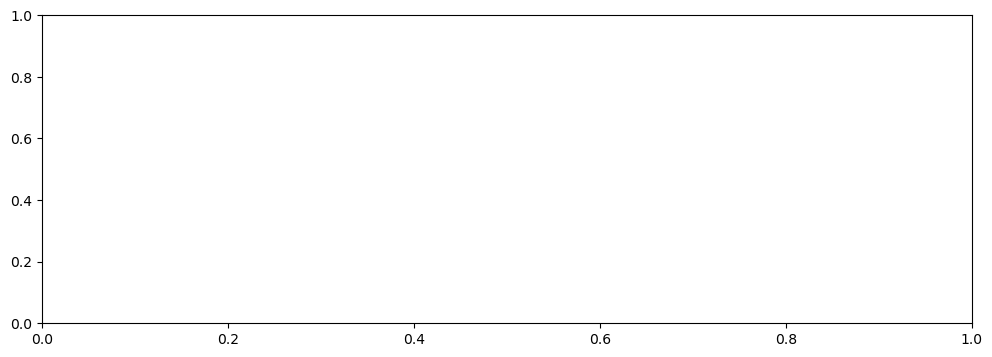

In [18]:
y0, y1 = 6530000, 6530000
geomodel.geomodel_transect_lith(structuralmodel, spatial, y0=y0, y1=y1)# z0 = -200, z1 = 300

### 6. Create synthetic heterogenous field

In [ ]:
#plt.plot(geomodel.zcenters[0], 'o')
#plt.plot(geomodel.zcenters[1], 'o')
#plt.plot(geomodel.zcenters[2], 'o')
#plt.plot(geomodel.zcenters[3], 'o')
#plt.show()  # Ensure the plot is displayed

In [ ]:
# LoopFlopy object
from loopflopy.properties import * #Properties
truth = Properties()
df = pd.read_excel('../data/example_data.xlsx', sheet_name = 'truth')
truth.make_gdf(geomodel, mesh, spatial, df)
print(truth.gdf)

      ID   Easting  Northing  Unit     kh     kv    sy        ss  \
0   OBS1  355120.0   6540562    TQ   10.0  2.000  0.12  0.000010   
1   OBS2  364415.7   6534636    TQ    5.0  0.100  0.20  0.000010   
2   OBS3  371000.0   6515000    TQ   10.0  0.500  0.08  0.000010   
3   OBS4  385447.0   6537497    TQ  100.0  3.000  0.25  0.000010   
4   OBS5  385200.0   6521000    TQ   10.0  0.600  0.10  0.000010   
5   OBS6  372541.0   6525478    TQ    2.0  0.100  0.11  0.000010   
6   OBS7  367502.0   6523500    TQ   20.0  2.000  0.15  0.000010   
7   OBS1  355120.0   6540562  Kcok    0.1  0.005  0.10  0.000050   
8   OBS2  364415.7   6534636  Kcok    0.2  0.003  0.10  0.000060   
9   OBS3  371000.0   6515000  Kcok    0.1  0.004  0.10  0.000090   
10  OBS4  385447.0   6537497  Kcok    0.5  0.050  0.10  0.000100   
12  OBS6  372541.0   6525478  Kcok    0.5  0.040  0.10  0.000006   
13  OBS7  367502.0   6523500  Kcok    0.5  0.010  0.10  0.000010   
14  OBS1  355120.0   6540562  Kwlp    1.0  0.020

In [ ]:
# Takes 2.5 minutes to run

anisotropy = (1., 0.5, 0.001)
CL = 10000.
nugget = 0.05
rebuild_threshold = 0.1

property = 'kh'
truth.kriging(geomodel, mesh, property, anisotropy, CL, nugget, rebuild_threshold)



######  TQ #########

OBS7 TQ disv_cell 4655 val 1.3010299956639813
OBS3 TQ disv_cell 6288 val 1.0
OBS4 TQ disv_cell 6452 val 2.0
OBS5 TQ disv_cell 6886 val 1.0
OBS6 TQ disv_cell 7432 val 0.3010299956639812
OBS2 TQ disv_cell 8637 val 0.6989700043360189
OBS1 TQ disv_cell 8996 val 1.0
points_values_3d.shape  (13800, 4)
sill  1.0430042850948544
7
prop_values  (13800,)
prop_values  (3, 4600)
######  Kcok #########

OBS7 Kcok disv_cell 18455 val -0.3010299956639812
OBS3 Kcok disv_cell 20088 val -1.0
OBS4 Kcok disv_cell 20252 val -0.3010299956639812
OBS6 Kcok disv_cell 21232 val -0.3010299956639812
OBS2 Kcok disv_cell 22437 val -0.6989700043360187
OBS1 Kcok disv_cell 22796 val -1.0
points_values_3d.shape  (13800, 4)
sill  0.5892769623726143
6
prop_values  (13800,)
prop_values  (3, 4600)
######  Kwlp #########

OBS7 Kwlp disv_cell 32255 val 1.0
OBS3 Kwlp disv_cell 33888 val 0.6989700043360189
OBS4 Kwlp disv_cell 34052 val 0.0
OBS5 Kwlp disv_cell 34486 val -0.3010299956639812
OBS6 Kwlp disv_ce

In [ ]:
# Takes 6.5 - 7 minutes to run
property = 'kv'
truth.kriging(geomodel, mesh, property, anisotropy, CL, nugget, rebuild_threshold)

property = 'sy'
truth.kriging(geomodel, mesh, property, anisotropy, CL, nugget, rebuild_threshold)

property = 'ss'
truth.kriging(geomodel, mesh, property, anisotropy, CL, nugget, rebuild_threshold)

######  TQ #########

OBS7 TQ disv_cell 4655 val 0.3010299956639812
OBS3 TQ disv_cell 6288 val -0.3010299956639812
OBS4 TQ disv_cell 6452 val 0.47712125471966244
OBS5 TQ disv_cell 6886 val -0.2218487496163564
OBS6 TQ disv_cell 7432 val -1.0
OBS2 TQ disv_cell 8637 val -1.0
OBS1 TQ disv_cell 8996 val 0.3010299956639812
points_values_3d.shape  (13800, 4)
sill  1.0430042850948544
7
prop_values  (13800,)
prop_values  (3, 4600)
######  Kcok #########

OBS7 Kcok disv_cell 18455 val -2.0
OBS3 Kcok disv_cell 20088 val -2.3979400086720375
OBS4 Kcok disv_cell 20252 val -1.3010299956639813
OBS6 Kcok disv_cell 21232 val -1.3979400086720375
OBS2 Kcok disv_cell 22437 val -2.5228787452803374
OBS1 Kcok disv_cell 22796 val -2.3010299956639813
points_values_3d.shape  (13800, 4)
sill  0.5892769623726143
6
prop_values  (13800,)
prop_values  (3, 4600)
######  Kwlp #########

OBS7 Kwlp disv_cell 32255 val -0.3010299956639812
OBS3 Kwlp disv_cell 33888 val -0.1549019599857432
OBS4 Kwlp disv_cell 34052 val -1.3

In [ ]:
print(geomodel.ncell_disv)
print(geomodel.ncell_disu)
print(truth.kh_layicpl_ma.shape)
print(truth.kh_disv.shape)
print(truth.kh_disu.shape)

print('Numer of geological layers = ', geomodel.nlg)
print('Number of sublayers per geological layer = ', geomodel.nls)
print('Number of model layers = ', geomodel.nlay)
top_layers = [geomodel.nls * geolay for geolay in range(geomodel.nlg)]
top_layers

69000
65853
(15, 4600)
(69000,)
(65853,)
Numer of geological layers =  5
Number of sublayers per geological layer =  3
Number of model layers =  15


[0, 3, 6, 9, 12]

In [ ]:
print(type(truth.kh_disu))

<class 'numpy.ndarray'>


0 TQ


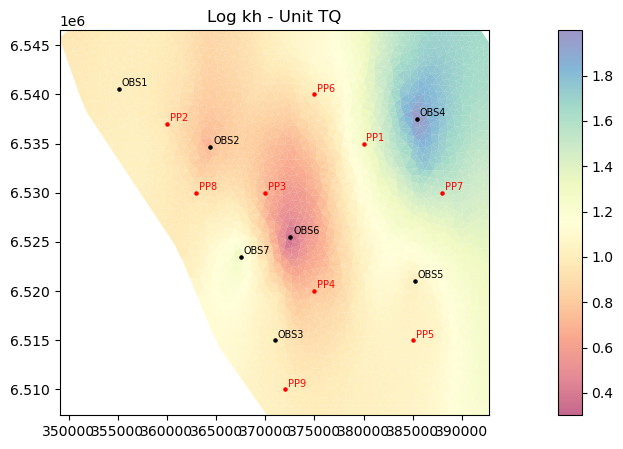

3 Kcok


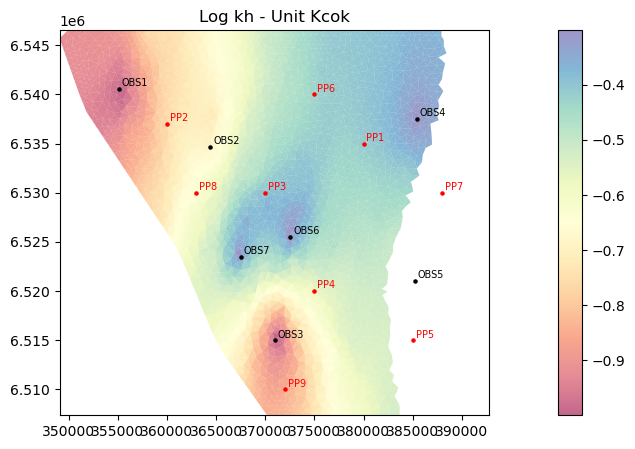

6 Kwlp


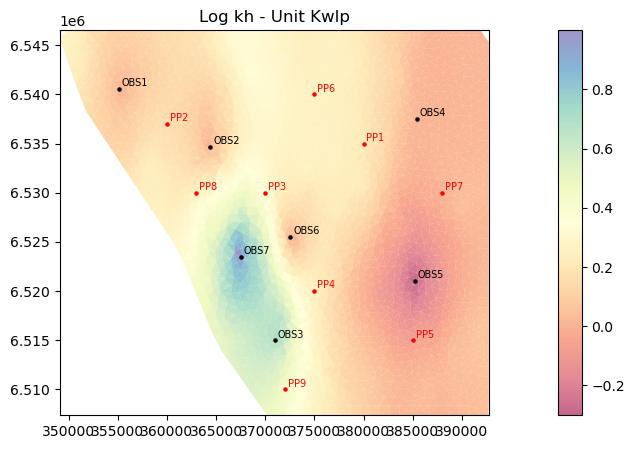

9 Kwlw


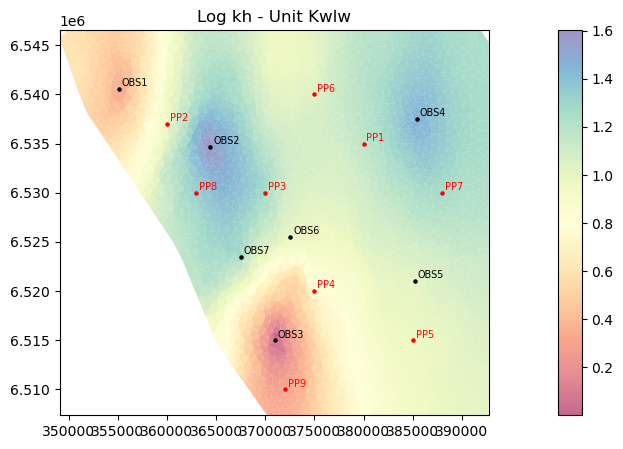

12 Kwlm


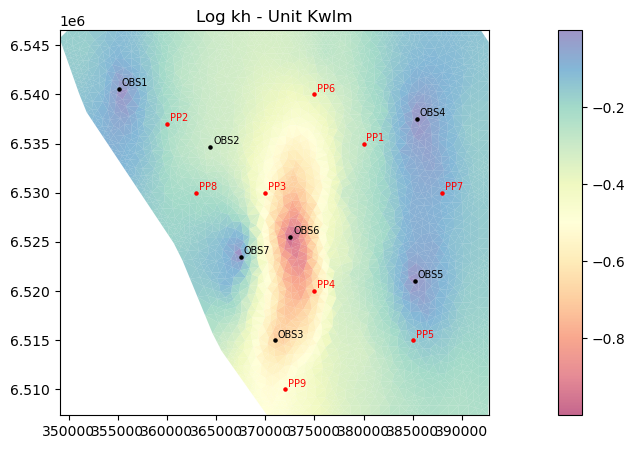

In [ ]:
for i, lay in enumerate(top_layers):  
    unit = geomodel.units[i]
    print(lay, unit)
    truth.plot_propfield(mesh, spatial, lay, unit, property = 'kh') # lay = model layer, unit = geological unit

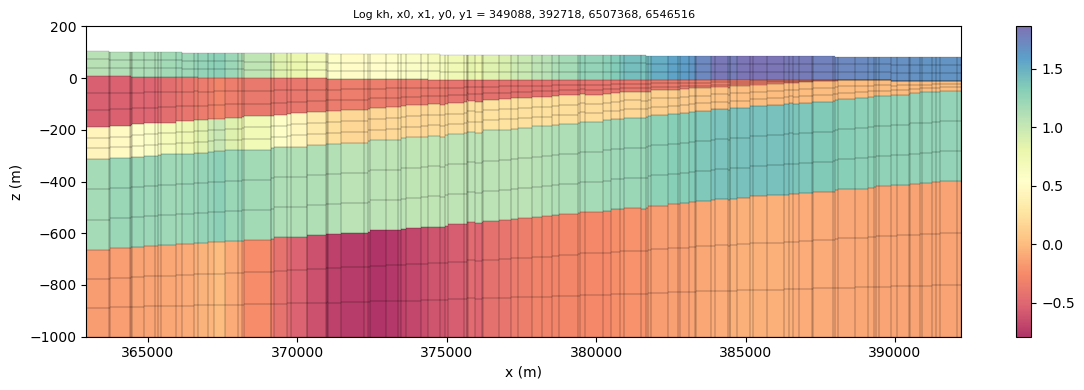

In [ ]:
#spatial.xsections = [[(355000, 6530000),(400000, 6540000)], [(365000, 6510000),(400000, 6525000)]]
x0, x1, y0, y1 = spatial.xsections[0][0][0], spatial.xsections[0][1][0], spatial.xsections[0][0][1], spatial.xsections[0][1][1]
truth.plot_propfield_usg(geomodel, spatial, x0, x1, y0, y1, property = 'kh')

In [ ]:
props = pd.read_excel(structuralmodel.geodata_fname, sheet_name = 'properties')
geomodel.iconvert_perlay = props.iconvert.tolist()

geomodel.fill_cell_properties_heterogeneous(truth)

   6. Filling cell properties...
ang1 shape  (15, 4600)
65853
angle1 shape  (65853,)
Time taken Block 6 Fill cell properties =  0.003043


### 6. Prepare Data for Flowmodel

In [ ]:
from process_data import Data
data = Data()

data.process_ic()#geomodel)
data.process_rch(geomodel, mesh)
data.process_chd(spatial, geomodel, mesh)

wel_q = [-100000, 0]
wel_qlay= [0, 0]
data.process_wel(geomodel, mesh, spatial, wel_q, wel_qlay)

Well screens  [(np.float64(-1000.0), np.float64(-1.0)), (np.float64(-1000.0), np.float64(2.0))]


#### Process Observations

In [ ]:
df = pd.read_excel('../data/example_data.xlsx', sheet_name = 'obs_bores')
import process_observations
gdf = process_observations.make_obs_gdf(df, geomodel, mesh, spatial)

from loopflopy.observations import Observations
observations = Observations(gdf)
observations.make_recarray() # makes recarray for flowmodel

print(observations.gdf)

     id         x        y    z   kh                  geometry  cell_disv  \
0  OBS1  355120.0  6540562  -50    5    POINT (355120 6540562)      18196   
1  OBS2  364415.7  6534636 -100    1  POINT (364415.7 6534636)      22437   
2  OBS3  371000.0  6515000 -100   10    POINT (371000 6515000)      24688   
3  OBS4  385447.0  6537497 -500  100    POINT (385447 6537497)      57052   
4  OBS5  385200.0  6521000 -100    1    POINT (385200 6521000)      34486   
5  OBS6  372541.0  6525478 -100    3    POINT (372541 6525478)      25832   
6  OBS7  367502.0  6523500  -50   10    POINT (367502 6523500)      13855   

   cell_disu  (lay,icpl)  lay  icpl                               obscell_xy  \
0      17149   (3, 4396)    3  4396  (355330.98438145826, 6540327.512844525)   
1      20364   (4, 4037)    4  4037  (364261.74735699437, 6534934.394501741)   
2      21895   (5, 1688)    5  1688   (371047.0029852411, 6515430.307171156)   
3      53905  (12, 1852)   12  1852   (385496.5384433281, 65373

### 8. Create and run steady-state flow model

In [ ]:
from loopflopy.flowmodel import Flowmodel
project.mfexe_name = '../exe/mf6.exe'
scenario = 'steadymodel'

fm = Flowmodel(scenario, project, data, observations, mesh, geomodel)
# Write and run flow model files
sim = fm.write_flowmodel(chd = True, wel = True, obs = True, rch = True)
fm.run_flowmodel(sim)

   Writing simulation and gwf for  steadymodel  ...
xt3d =  True
   Time taken to write flow model =  20.016196
Running simulation for  steadymodel  ...
Model success =  True
   run_time =  11.679035
['DISU', 'NPF', 'IC', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 65853)


In [ ]:
utils.print_object_details(fm)

Methods:
get_watertable
plot_plan
plot_transect
plot_watertable
run_flowmodel
write_flowmodel

Variables
chd
chdflow
data
geomodel
gwf
head
lith
logk11
logk33
mesh
newtonoptions
obs
obsdata
observations
project
rch
runtime
scenario
spd
staggered
wel
xt3d


In [ ]:
# IF A PROBLEM NODE FROM MFSIM, CAN LOT LOCATION HERE!
#utils.plot_node(1508-1, geomodel, structuralmodel, spatial, sim, scenario, z1 = 500, features = ['fault'])

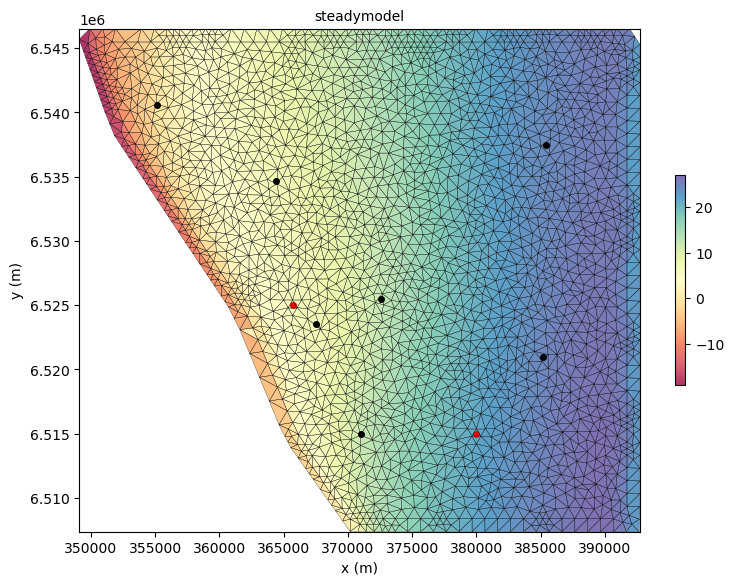

In [ ]:
watertable = fm.get_watertable(geomodel, fm.head)
fm.plot_watertable(spatial, mesh, geomodel, fm, watertable,)#, extent, vmin, vmax

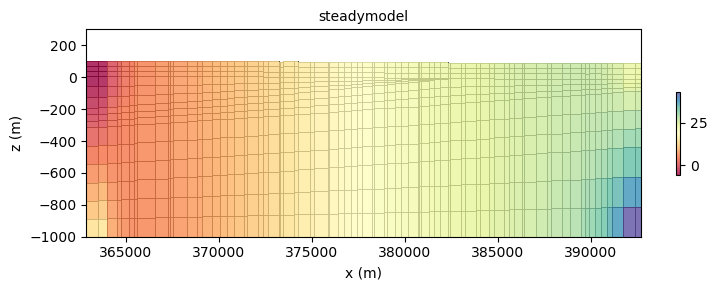

In [ ]:
fm.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)

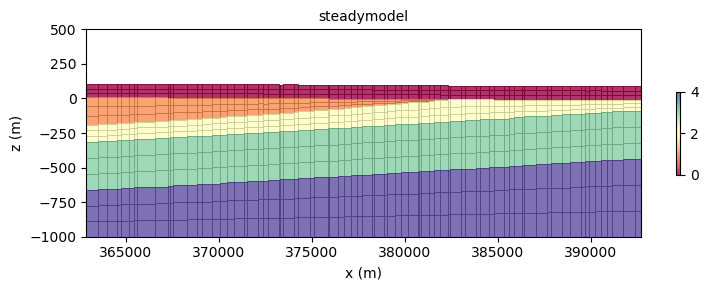

In [ ]:
fm.plot_transect(spatial, structuralmodel, 'lith', y0 = 6520000, y1 = 6520000)

In [ ]:
obj = fm
methods = [func for func in dir(obj) if callable(getattr(obj, func)) and not func.startswith("__")]
print("Methods in the class:  ",methods)
attributes = [attr for attr in dir(obj) if not callable(getattr(obj, attr)) and not attr.startswith("__")]
print("\nAttributes in the class:  ", attributes)

#for attribute, value in flowmodel.data.__dict__.items(): print(attribute)

Methods in the class:   ['get_watertable', 'plot_plan', 'plot_transect', 'plot_watertable', 'run_flowmodel', 'write_flowmodel']

Attributes in the class:   ['chd', 'chdflow', 'data', 'geomodel', 'gwf', 'head', 'lith', 'logk11', 'logk33', 'mesh', 'newtonoptions', 'obs', 'obsdata', 'observations', 'project', 'rch', 'runtime', 'scenario', 'spd', 'staggered', 'wel', 'xt3d']


### Create a steady state "truth"

In [ ]:
# Get convert obs package to arrays of oberservation heads
heads_truth = fm.head

# Get times
csv_file = os.path.join('../results/ref_past.csv')
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
csv_file = os.path.join(project.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2
times = list(times_past) + list(times_future)

# Pickle reference results
fname = P.results + 'times.pkl'
pickle.dump(times, open(os.path.join(fname),'wb'))
fname = '../results/ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(fname),'wb'))


### 9. Create and run transient flow model

In [ ]:
scenario = 'transientmodel'
well_q = [-2000, -2000]
data.process_wel(geomodel, mesh, spatial, well_q, wel_qlay)
data.strt = fm.head
fm2 = Flowmodel(scenario, project, data, observations, mesh, geomodel)

perlen = 2 * 365 # length of period (days)
nts = 12         # number of time steps for this period
fm2.perioddata = [(perlen, nts, 1.1)] # perlen, nts, tsmult

Well screens  [(np.float64(-1000.0), np.float64(32.0)), (np.float64(-1000.0), np.float64(6.0))]


In [ ]:
sim = fm2.write_flowmodel(transient = True, chd = True, wel = True, obs = True, rch = True)

   Writing simulation and gwf for  transientmodel  ...
   Time taken to write flow model =  5.524102


In [ ]:
fm2.run_flowmodel(sim, transient = True)

Running simulation for  transientmodel  ...
Model success =  True
   run_time =  10.117995
['DISU', 'NPF', 'IC', 'STO', 'WEL_0', 'CHD_0', 'RCH_0', 'OBS_0', 'OC']
head results shape  (1, 13358)


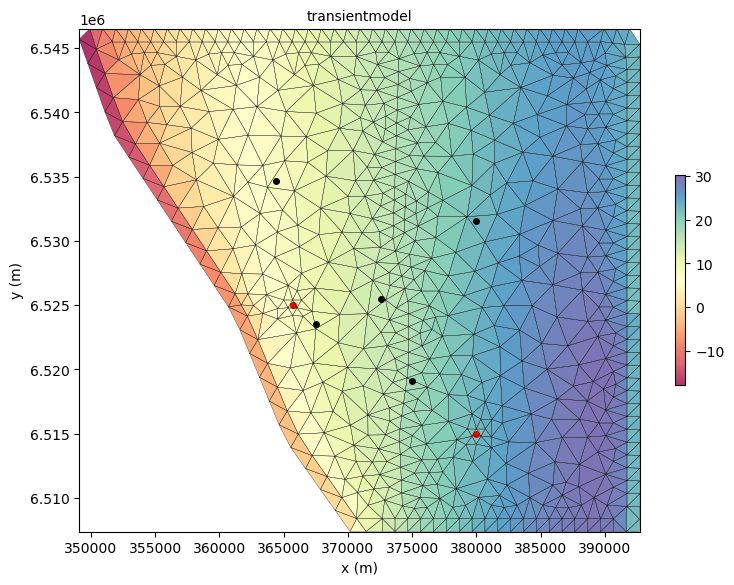

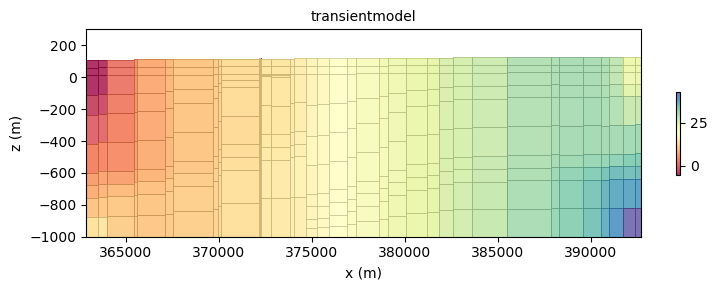

In [ ]:
watertable = fm2.get_watertable(geomodel, fm2.head)
fm2.plot_watertable(spatial, mesh, geomodel, fm2, watertable,)#, extent, vmin, vmax
fm2.plot_transect(spatial, structuralmodel, 'head',  y0 = 6520000, y1 = 6520000, z1 = 300)#, X0, X1, Y0, Y1)

#### Create "truth" observations and plot

In [ ]:
# Get convert obs package to arrays of oberservation heads
R.ref_steady  = functions.process_obs_steady(P, R)
R.ref_past    = functions.process_obs_past(P, R)
R.ref_future  = functions.process_obs_future(P, R)

# Get times
csv_file = os.path.join(P.workspace, R.modelname + "_past.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_past = df.iloc[:,0]/365
csv_file = os.path.join(P.workspace, R.modelname + "_future.csv")
data_set = pd.read_csv(csv_file, header=0)
df = pd.DataFrame(data_set)
times_future = df.iloc[:,0]/365+2
times = list(times_past) + list(times_future)

# Pickle reference results
fname = P.results + 'ref_ss.pkl'
pickle.dump(R.ref_steady, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_past.pkl'
pickle.dump(R.ref_past, open(os.path.join(fname),'wb'))
fname = P.results + 'ref_future.pkl'
pickle.dump(R.ref_future, open(os.path.join(fname),'wb'))
fname = P.results + 'times.pkl'
pickle.dump(times, open(os.path.join(fname),'wb'))

In [ ]:
# PLOT REFERENCE OBSERVATIONS
import matplotlib.pyplot as plt
colors = ['red','green','blue']
R.ref_future.shape
for j in range(P.nobs):
    for i in range(P.nzobs):
        plt.plot(times_past, R.ref_past[j][i],'o', ms = 2, color = colors[i])
        plt.plot(times_future, R.ref_future[j][i],'o', ms = 2, color = colors[i])
plt.xlabel('Time (years)')
plt.ylabel('Head (m)')

In [ ]:
# CREATE SYNTHETIC OBSERVATIONS BY PERTURBING ACTUAL HEADS
err = 0.05
hobs_ref = np.copy(R.ref_past)    
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            hobs_ref[i][j][k] += np.random.normal(0.,err) # Perturb samples either side of measurement
plt.plot(R.ref_past.flatten(), 'o', ms = 1, label = 'actual heads')
plt.plot(hobs_ref.flatten(),'o', ms = 1, label = 'perturbed heads')
plt.xlabel('Observation index')
plt.ylabel('Head (m)')
plt.legend()

In [ ]:
%run ./figures.ipynb   
figure8(P, R)

#### Prepare PEST input arrays

In [ ]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - HEADS.INS)
hobs_ref.shape #(5, 3, 12)
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            print('l1 [OBS%i_%i.%i]1:20' %(i, j, k))

In [ ]:
# PRINTING TRUTH HEADS FOR HISTORY MATCHING (PEST - CONTROL.PST)
for i in range(P.nobs):
    for j in range(P.nzobs):
        for k in range(hobs_ref.shape[2]):
            print('OBS%i_%i.%i  %f  10.0  head' %(i, j, k, hobs_ref[i, j, k]))

#### Prepare parameter bounds

In [ ]:
# LOG
k_min = [0, -2, 0, -2, -1, -2.5, -0.5, -2.5, -5, -5, -5]
k_max = [1, -1, 1, -1, 0, -1.5, 0.5, -1.5, -4, -4, -4]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]

print(k_min)
print(k_max)
print(k_mean)

In [ ]:
pickleoff = open('../results/reference.pkl','rb')
reference = pickle.load(pickleoff)
pickleoff.close()

# BLUE - MAX/MIN
# ORANGE - MEAN
# RED - ACTUAL
fig = plt.figure(figsize = (12,5))
plt.plot(np.linspace(0,10,11), k_min, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_max, 'o', color = 'blue')
plt.plot(np.linspace(0,10,11), k_mean, 'o', color = 'orange')
plt.plot(np.linspace(0,10,11), logfunc(reference[0] + reference[1] + reference[2][1:]), 'o', color = 'red')
plt.ylabel('Log')
plt.xticks(np.linspace(0,10,11), ['loghk0', 'loghk1', 'loghk2', 'loghk3', 
                                'logvk0', 'logvk1', 'logvk2', 'logvk3',
                                'logss1', 'logss2', 'logss2'])#, logss1, logss2, logss3, sy0, cp])
plt.show()

#### Pilot Point Setup

In [ ]:
properties = Properties() # set up a new properties object
df = pd.read_excel('../data/example_data.xlsx', sheet_name = 'pilot_points')
properties.make_gdf(geomodel, mesh, spatial, df)
#print(properties.gdf)

anisotropy = (1., 1., 0.0001)
CL = 5000.
nugget = 0.05
rebuild_threshold = 0.1

properties.kriging(geomodel, mesh, anisotropy, CL, nugget, rebuild_threshold)

#spatial.xsections = [[(355000, 6530000),(400000, 6540000)], [(365000, 6510000),(400000, 6525000)]]
x0, x1, y0, y1 = spatial.xsections[0][0][0], spatial.xsections[0][1][0], spatial.xsections[0][0][1], spatial.xsections[0][1][1]
properties.plot_propfield_usg(geomodel, spatial, x0, x1, y0, y1, property = 'kh')

'''# LOG
k_min = [0, -2, 0, -2]
k_max = [1, -1, 1, -1]
k_mean = [(k_max[i] - k_min[i])/2 + k_min[i] for i in range(len(k_min))]

print(k_min)
print(k_max)
print(k_mean)

Min.append(k_min[i+8]) 
Max.append(k_max[i+8])

# LAYER K
nr_param = 200 # Create lots of parameter sets
nr = 100 # How many successful flow models we want
import random 
logfunc = lambda e: np.log10(e)

def normal_sampling(mu, sigma, nr_param):
    nums = [] 
    count = 0
    while count < nr_param:
        temp = random.gauss(mu,sigma) 
        if temp >= mu - 3 * sigma and temp <= mu + 3*sigma:
            nums.append(temp)
            count += 1
    return(nums)

hk_mu = np.copy(hk) # from variables.ipynb
hk_mu_log = logfunc(hk_mu)
hk_sigma_log = [0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66]

vk_mu = np.copy(vk) # from variables.ipynb
vk_mu_log = logfunc(vk_mu)
vk_sigma_log = [0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66, 0.66]

hk_parameters = []
vk_parameters = []

for n in range(8): # for each layer
    hk_parameters.append(normal_sampling(hk_mu_log[n], hk_sigma_log[n], nr_param))'''

#### History Matching